In [1]:
import math

import jax
import jax.numpy as jnp
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from matplotlib import pyplot as plt

from config import Config
from data import load_dataset
from model import (L_attn, L_hopf, force_penalty_weight, get_xi_attn_embed,
                   get_xi_hopf, logits_from_v, run_model_inference_steps)
from utils import load_metrics, load_params

In [2]:
params = load_params("data/model_best.npz")

losses = load_metrics("data/losses.json")
accs = load_metrics("data/accs.json")

losses_steps = np.array(losses["step"])
losses_all   = np.array(losses["loss"])
accs_steps   = np.array(accs["step"])
accs_all     = np.array(accs["accuracy"])

train_X, train_y, valid_X, valid_y = load_dataset(filename_prefix="parity_data")

W0000 00:00:1765757121.034195   85903 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1765757121.047556   85903 service.cc:145] XLA service 0x11e6d36c0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765757121.047701   85903 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1765757121.049196   85903 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1765757121.049203   85903 mps_client.cc:384] XLA backend will use up to 22906109952 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [3]:
def run_inference(ctx_tokens):
    ctx_bits = jnp.asarray(ctx_tokens, dtype=jnp.int32)
    (V_T, H_att_T, H_hopf_T), traj = run_model_inference_steps(ctx_bits, params)
    return traj

arr = jnp.array([
    [1, 1, 0, 0, 1, 0, 1, 0],
    [0, 1, 0, 0, 0, 1, 1, 0],
    [1, 0, 1, 1, 0, 0, 0, 1],
    [0, 0, 0, 1, 1, 0, 1, 1],
])

traj = run_inference(arr)

/var/folders/dm/vn6f0f793gb_8nbzp1vf2lh40000gn/T/ipykernel_17199/169046328.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues", n_lines)


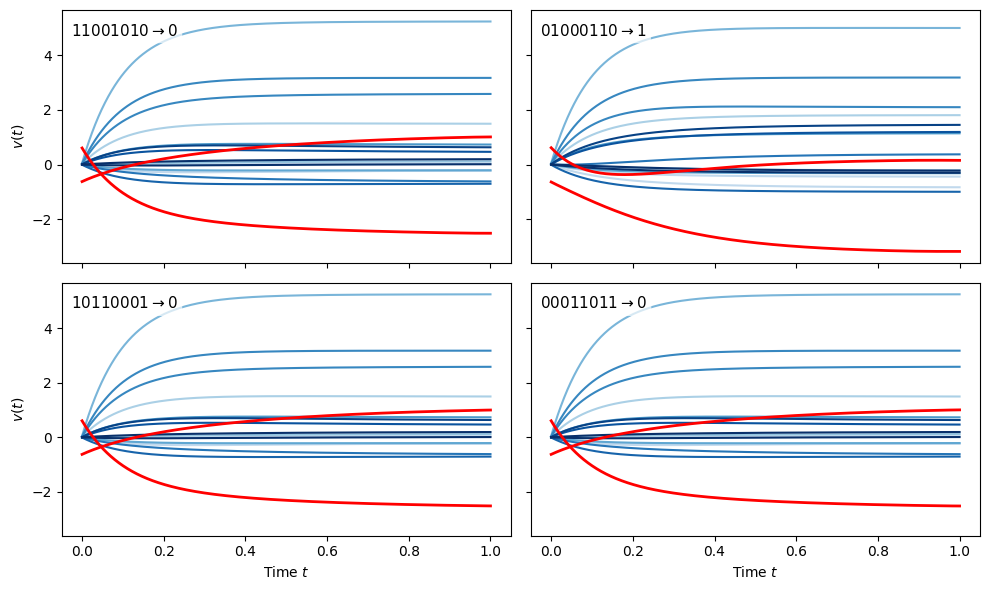

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=True)

# Create the colormap
n_lines = traj["V"].shape[-1]
cmap = cm.get_cmap("Blues", n_lines)
colors = cmap(jnp.linspace(0.2, 1.0, n_lines))  # start from lighter blue

for i in range(4):
    visible_traj = traj["V"][:, i, :]  # (n_steps, D)
    logits = logits_from_v(params, visible_traj)
    predicted_token = jnp.argmax(logits[-1], axis=-1)
    ax = axs[i // 2, i % 2]
    ts = jnp.linspace(0, Config.T_final, Config.n_steps)

    # Plot each dimension trajectory in a blue gradient
    for d in range(visible_traj.shape[-1]):
        ax.plot(ts, visible_traj[:, d], color=colors[d])

    # plot logits
    ax.plot(
        ts,
        jnp.asarray(logits[:, 0]),
        color="red",
        linestyle="-",
        linewidth=2.0,
        label="Predicted token logit",
    )
    ax.plot(
        ts,
        jnp.asarray(logits[:, 1]),
        color="red",
        linestyle="-",
        linewidth=2.0,
        label="Predicted token logit",
    )

    # Place the text title inside the plot (top-left)
    ax.text(
        0.02,
        0.95,
        f'${"".join([str(x) for x in arr[i].tolist()])} \\rightarrow {predicted_token}$',
        transform=ax.transAxes,
        fontsize=11,
        va="top",
        ha="left",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, edgecolor="none"
        ),
    )

axs[1, 1].set_xlabel("Time $t$")
axs[1, 0].set_xlabel("Time $t$")
axs[0, 0].set_ylabel("$v(t)$")
axs[1, 0].set_ylabel("$v(t)$")

plt.tight_layout()
plt.show()

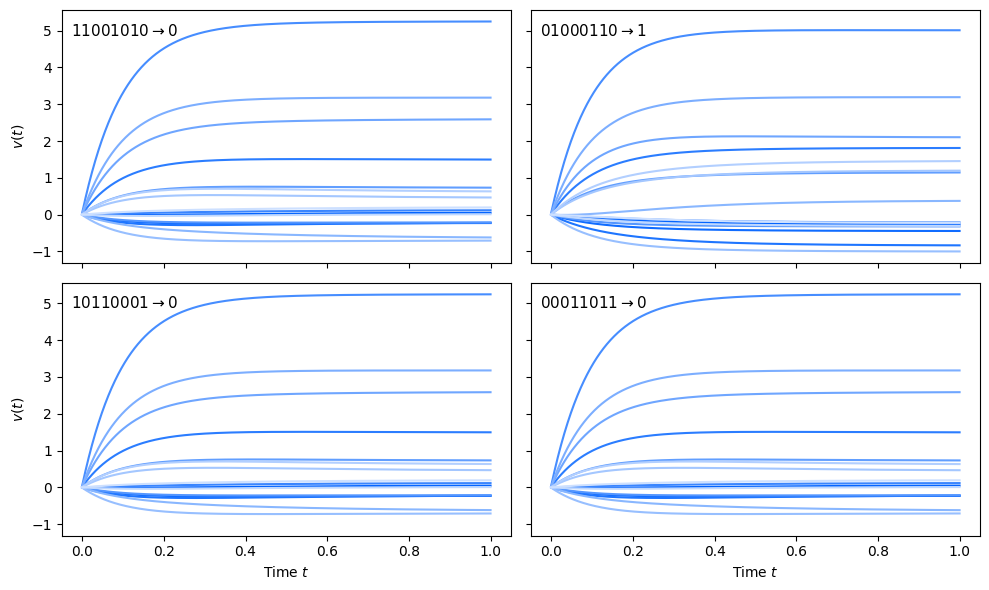

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=True)

# --- Generate shades of the same base color (#0364FF) using NumPy floats ---
base_color = np.array(mcolors.to_rgb("#0364FF"))  # (3,) floats in [0,1]
n_lines = int(traj["V"].shape[-1])
ws = np.linspace(0.0, 0.8, n_lines)  # blend factor toward white
shades = [
    tuple(((1.0 - w) * base_color + w * 1.0).tolist()) for w in ws
]  # list of (r,g,b)

for i in range(4):
    visible_traj = traj["V"][:, i, :]  # (n_steps, D)
    logits = logits_from_v(params, visible_traj[-1])
    predicted_token = jnp.argmax(logits, axis=-1)
    ax = axs[i // 2, i % 2]

    ts = np.linspace(0, Config.T_final, Config.n_steps)  # NumPy for Matplotlib

    # plot each line with a different shade of #0364FF
    for d in range(visible_traj.shape[-1]):
        ax.plot(ts, np.asarray(visible_traj[:, d]), color=shades[d])

    # put the title text inside the subplot (top-left)
    ax.text(
        0.02,
        0.95,
        f'${"".join([str(x) for x in arr[i].tolist()])} \\rightarrow {predicted_token}$',
        transform=ax.transAxes,
        fontsize=11,
        va="top",
        ha="left",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.0, edgecolor="none"
        ),
    )

axs[1, 1].set_xlabel("Time $t$")
axs[1, 0].set_xlabel("Time $t$")
axs[0, 0].set_ylabel("$v(t)$")
axs[1, 0].set_ylabel("$v(t)$")

plt.tight_layout()
plt.show()

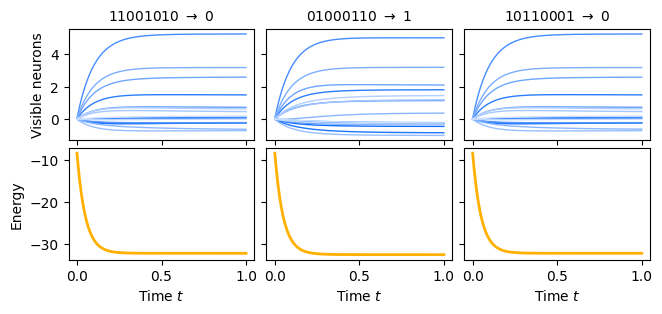

In [6]:
# --- config / helpers ---
T_final = float(Config.T_final)
n_steps = int(Config.n_steps)
ts = np.linspace(0.0, T_final, n_steps)

# first three contexts
cols = 3
ctx_idx = [0, 1, 2]

# colors: generate D shades of #0364FF
base_color = np.array(mcolors.to_rgb("#0364FF"))
D = int(traj["V"].shape[-1])
ws = np.linspace(0.0, 0.8, D)  # blend toward white
shades = [tuple(((1.0 - w) * base_color + w * 1.0).tolist()) for w in ws]

fig, axs = plt.subplots(
    nrows=2, ncols=cols, figsize=(6.5, 3), sharex=True, sharey="row"
)
for c, i in enumerate(ctx_idx):
    # --- data slices for context i ---
    V_traj = np.asarray(traj["V"][:, i, :])  # (n_steps, D)
    E_traj = np.asarray(traj["energy"][:, i])  # (n_steps,)
    # prediction from final v(T)
    logits = logits_from_v(params, V_traj[-1])
    pred = int(jnp.argmax(logits))
    # make a neat bitstring label
    bits = "".join(str(int(b)) for b in np.asarray(arr[i]).tolist())

    # --- top: v(t) trajectories ---
    ax_top = axs[0, c]
    for d in range(D):
        ax_top.plot(ts, V_traj[:, d], color=shades[d], linewidth=1.0)
    ax_top.set_ylabel(r"Visible neurons" if c == 0 else None)
    # column label
    ax_top.set_title(rf"${bits}\ \rightarrow\ {pred}$", fontsize=10)

    # --- bottom: energy ---
    ax_bot = axs[1, c]
    ax_bot.plot(ts, E_traj, color="#FFB000", linewidth=2.0)
    if c == 0:
        ax_bot.set_ylabel(r"Energy")

# shared x label on bottom row
for c in range(cols):
    axs[1, c].set_xlabel(r"Time $t$")

# tidy layout
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)
plt.savefig("parity_inference.pdf", bbox_inches="tight")
plt.show()

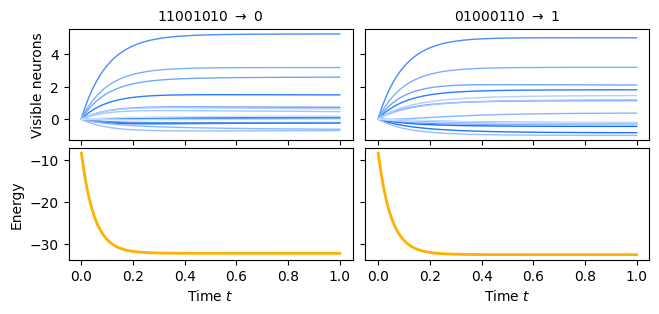

In [7]:
# --- config / helpers ---
T_final = float(Config.T_final)
n_steps = int(Config.n_steps)
ts = np.linspace(0.0, T_final, n_steps)

# first three contexts
cols = 2
ctx_idx = [0, 1]

# colors: generate D shades of #0364FF
base_color = np.array(mcolors.to_rgb("#0364FF"))
D = int(traj["V"].shape[-1])
ws = np.linspace(0.0, 0.8, D)  # blend toward white
shades = [tuple(((1.0 - w) * base_color + w * 1.0).tolist()) for w in ws]

fig, axs = plt.subplots(
    nrows=2, ncols=cols, figsize=(6.5, 3), sharex=True, sharey="row"
)
for c, i in enumerate(ctx_idx):
    # --- data slices for context i ---
    V_traj = np.asarray(traj["V"][:, i, :])  # (n_steps, D)
    E_traj = np.asarray(traj["energy"][:, i])  # (n_steps,)
    # prediction from final v(T)
    logits = logits_from_v(params, V_traj[-1])
    pred = int(jnp.argmax(logits))
    # make a neat bitstring label
    bits = "".join(str(int(b)) for b in np.asarray(arr[i]).tolist())

    # --- top: v(t) trajectories ---
    ax_top = axs[0, c]
    for d in range(D):
        ax_top.plot(ts, V_traj[:, d], color=shades[d], linewidth=1.0)
    ax_top.set_ylabel(r"Visible neurons" if c == 0 else None)
    # column label
    ax_top.set_title(rf"${bits}\ \rightarrow\ {pred}$", fontsize=10)

    # --- bottom: energy ---
    ax_bot = axs[1, c]
    ax_bot.plot(ts, E_traj, color="#FFB000", linewidth=2.0)
    if c == 0:
        ax_bot.set_ylabel(r"Energy")

# shared x label on bottom row
for c in range(cols):
    axs[1, c].set_xlabel(r"Time $t$")

# tidy layout
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)
plt.savefig("parity_inference2.pdf", bbox_inches="tight")
plt.show()

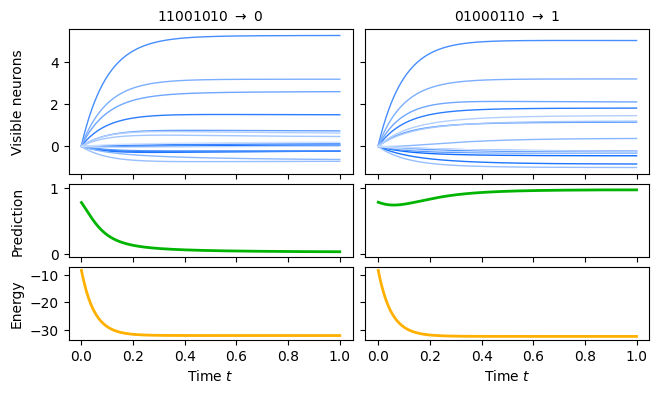

In [8]:
# --- config / helpers ---
T_final = float(Config.T_final)
n_steps = int(Config.n_steps)
ts = np.linspace(0.0, T_final, n_steps)

# contexts to show
ctx_idx = [0, 1]
cols = len(ctx_idx)

# colors: generate D shades of #0364FF
base_color = np.array(mcolors.to_rgb("#0364FF"))
D = int(traj["V"].shape[-1])
ws = np.linspace(0.0, 0.8, D)  # blend toward white
shades = [tuple(((1.0 - w) * base_color + w * 1.0).tolist()) for w in ws]

# 3 rows: visibles / prediction / energy
fig, axs = plt.subplots(
    nrows=3,
    ncols=cols,
    figsize=(6.5, 3.8),
    sharex=True,
    sharey="row",
    gridspec_kw={"height_ratios": [2, 1, 1]},  # <-- make middle thinner
)

for c, i in enumerate(ctx_idx):
    # --- data slices for context i ---
    V_traj = np.asarray(traj["V"][:, i, :])  # (n_steps, D)
    E_traj = np.asarray(traj["energy"][:, i])  # (n_steps,)

    # logits over the whole trajectory: shape (n_steps, C)
    logits_traj = np.asarray(logits_from_v(params, V_traj))
    # prediction from final v(T)
    pred = int(np.argmax(logits_traj[-1]))

    # softmax over classes at each time
    logits_shift = logits_traj - logits_traj.max(axis=-1, keepdims=True)
    exp_logits = np.exp(logits_shift)
    probs = exp_logits / exp_logits.sum(axis=-1, keepdims=True)

    # probability that output is class "1"
    p1_traj = probs[:, 1]  # assumes class-1 is index 1

    # bitstring label
    bits = "".join(str(int(b)) for b in np.asarray(arr[i]).tolist())

    # --- top: v(t) trajectories ---
    ax_top = axs[0, c]
    for d in range(D):
        ax_top.plot(ts, V_traj[:, d], color=shades[d], linewidth=1.0)
    if c == 0:
        ax_top.set_ylabel(r"Visible neurons", labelpad=18)
    ax_top.set_title(rf"${bits}\ \rightarrow\ {pred}$", fontsize=10)

    # --- middle: prediction probability ---
    ax_mid = axs[1, c]
    ax_mid.plot(ts, p1_traj, linewidth=2.0, color="#01B401")
    ax_mid.set_ylim(-0.05, 1.05)
    if c == 0:
        ax_mid.set_ylabel(r"Prediction", labelpad=18)  # p(y=1)
    ax_mid.set_yticks([0.0, 1.0])

    # --- bottom: energy ---
    ax_bot = axs[2, c]
    ax_bot.plot(ts, E_traj, color="#FFB000", linewidth=2.0)
    if c == 0:
        ax_bot.set_ylabel(r"Energy")

# shared x label on bottom row
for c in range(cols):
    axs[2, c].set_xlabel(r"Time $t$")

plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)
plt.savefig("parity_inference_with_prediction.pdf", bbox_inches="tight")
plt.show()

In [9]:
def infer_forward_euler_with_engergies(params, V0, ctx_bits, save_hist: bool = False):
    """
    Returns:
      V_T: (B, D) terminal visible state
      F_T: (B, D) force at V_T, i.e. dV/dt = -(1/tau_v) * dE/dV at V_T
      E_traj: (T,) scalar energy (sum over batch) recorded at each step

    If save_hist is True, also returns:
      V_traj: (T, B, D) visible states after each update
      H_att_traj: (T, B, L) attention preactivations after each update
      H_hopf_traj: (T, B, M) hopfield preactivations after each update
    """
    # Xi_seq with positive-used xi
    xi_attn_embed = get_xi_attn_embed(params)  # (vocab_size, D)
    batch_xi_attn = xi_attn_embed[ctx_bits]  # (B, L, D)
    step_v = Config.step_size / Config.tau_v
    step_h = Config.step_size / Config.tau_h

    B = V0.shape[0]

    # Initial pre-activations
    H_attn0 = jnp.einsum('bld,bd->bl', batch_xi_attn, V0) + params['b'] # (B, L)
    H_hopf0 = V0 @ get_xi_hopf(params).T + params['c'] # (B, M)

    # Energy for batch with Xi captured (no per-step allocations beyond carry)
    def batch_energy(params, V, H_attn, H_hopf, F_attn, F_hopf):
        def _sample_energy(v, h_attn, h_hopf, f_attn, f_hopf, xi_attn):
            dv = v - params["a"]
            vis = 0.5 * jnp.dot(dv, dv)
            coupling = jnp.dot(v, xi_attn.T @ f_attn + get_xi_hopf(params).T @ f_hopf)
            att_bias = jnp.dot(f_attn, h_attn - params["b"])
            hopf_bias = jnp.dot(f_hopf, h_hopf - params["c"])
            return (
                vis - coupling + att_bias + hopf_bias - L_attn(h_attn) - L_hopf(h_hopf)
            )

        Eb = jax.vmap(_sample_energy, in_axes=(0, 0, 0, 0, 0, 0))(
            V, H_attn, H_hopf, F_attn, F_hopf, batch_xi_attn
        )
        return jnp.sum(Eb)

    grad_E = jax.value_and_grad(batch_energy, argnums=(1, 4, 5))  # grads wrt (V, P, A)

    def grads_activation(V, H_attn, H_hopf):
        F_attn = jax.nn.softmax(Config.beta * H_attn, axis=-1)
        F_hopf = jnp.maximum(H_hopf, 0.0)
        E, (dE_dV, dE_dF_attn, dE_dF_hopf) = grad_E(params, V, H_attn, H_hopf, F_attn, F_hopf)
        return dE_dV, dE_dF_attn, dE_dF_hopf, E

    def body(i, carry):
        V, H_attn, H_hopf, E_traj, V_traj, H_attn_traj, H_hopf_traj = carry
        dE_dV, dE_dF_attn, dE_dF_hopf, E = grads_activation(V, H_attn, H_hopf)
        V = V - step_v * dE_dV
        H_attn = H_attn - step_h * dE_dF_attn
        H_hopf = H_hopf - step_h * dE_dF_hopf

        E_traj = E_traj.at[i].set(E)
        V_traj = V_traj.at[i].set(V)
        H_attn_traj = H_attn_traj.at[i].set(H_attn)
        H_hopf_traj = H_hopf_traj.at[i].set(H_hopf)
        return (V, H_attn, H_hopf, E_traj, V_traj, H_attn_traj, H_hopf_traj)

    # initialize energy trajectory buffer
    E_traj0 = jnp.zeros((Config.n_steps,), dtype=jnp.float32)

    # initialize history buffers (T, B, ...)
    V_traj0 = jnp.zeros((Config.n_steps, B, Config.D), dtype=jnp.float32)
    H_attn_traj0 = jnp.zeros((Config.n_steps, B, Config.L), dtype=jnp.float32)
    H_hopf_traj0 = jnp.zeros((Config.n_steps, B, Config.M), dtype=jnp.float32)

    V_T, H_attn_T, H_hopf_T, E_traj, V_traj, H_attn_traj, H_hopf_traj = jax.lax.fori_loop(
        0, Config.n_steps, body, (V0, H_attn0, H_hopf0, E_traj0, V_traj0, H_attn_traj0, H_hopf_traj0)
    )

    # Force at terminal state (no extra allocations beyond one grad eval)
    dE_dV_T, _, _, _ = grads_activation(V_T, H_attn_T, H_hopf_T)
    F_T = -(1.0 / Config.tau_v) * dE_dV_T

    if save_hist:
        return V_T, F_T, E_traj, V_traj, H_attn_traj, H_hopf_traj
    else:
        return V_T, F_T, E_traj

(best) processed 50/52 val examples; last E0=-7.8856611251831055
(best) processed 52/52 val examples; last E0=-7.8856611251831055
E_stack_val_best shape: (1000, 52)


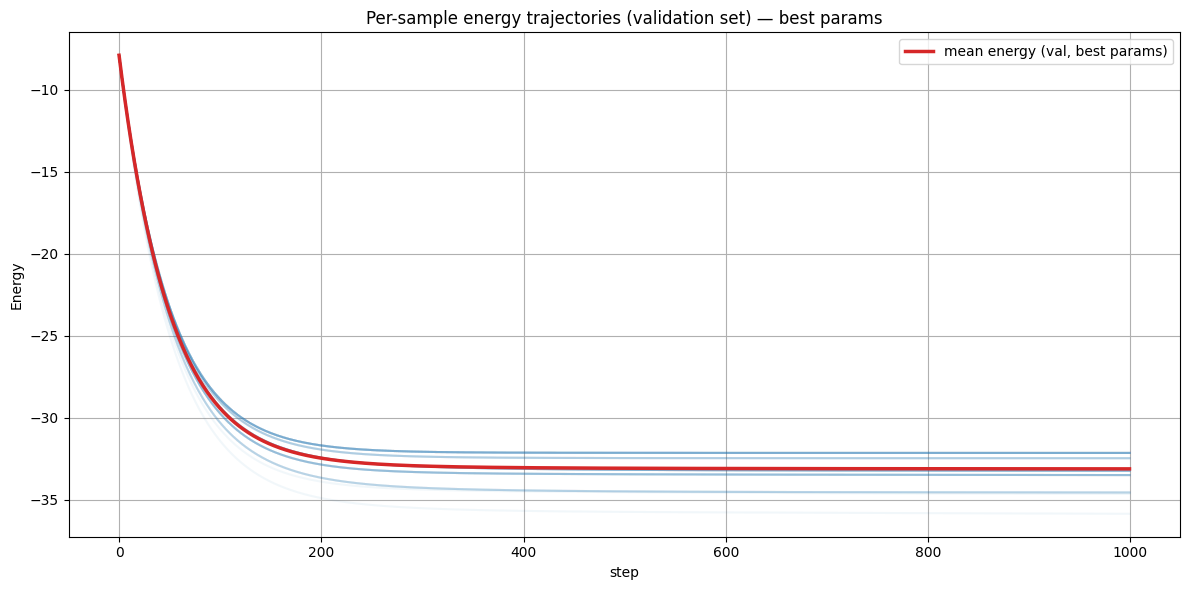

In [10]:
# Per-sample inference on validation set
results_val_best = []
V0 = jnp.zeros((1, Config.D))
num_val = int(valid_X.shape[0])
for i in range(num_val):
    ctx = valid_X[i:i+1]
    V_T, F_T, E_traj = infer_forward_euler_with_engergies(params, V0, ctx) # type: ignore
    results_val_best.append(E_traj)
    if (i + 1) % 50 == 0 or i == num_val - 1:
        print(f"(best) processed {i+1}/{num_val} val examples; last E0={float(E_traj[0])}")

E_stack_val_best = jnp.stack(results_val_best, axis=1)
print('E_stack_val_best shape:', E_stack_val_best.shape)

# Plot all per-sample validation trajectories with mean overlay
E_val_best = np.array(E_stack_val_best)
T, N = E_val_best.shape
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(E_val_best[:, i], color='C0', alpha=0.06)
mean_val_best = E_val_best.mean(axis=1)
plt.plot(mean_val_best, color='C3', linewidth=2.5, label='mean energy (val, best params)')
plt.xlabel('step')
plt.ylabel('Energy')
plt.title('Per-sample energy trajectories (validation set) — best params')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(best) processed 200/204 train examples; last E0=-7.8856611251831055
(best) processed 204/204 train examples; last E0=-7.8856611251831055
E_stack_train_best shape: (1000, 204)


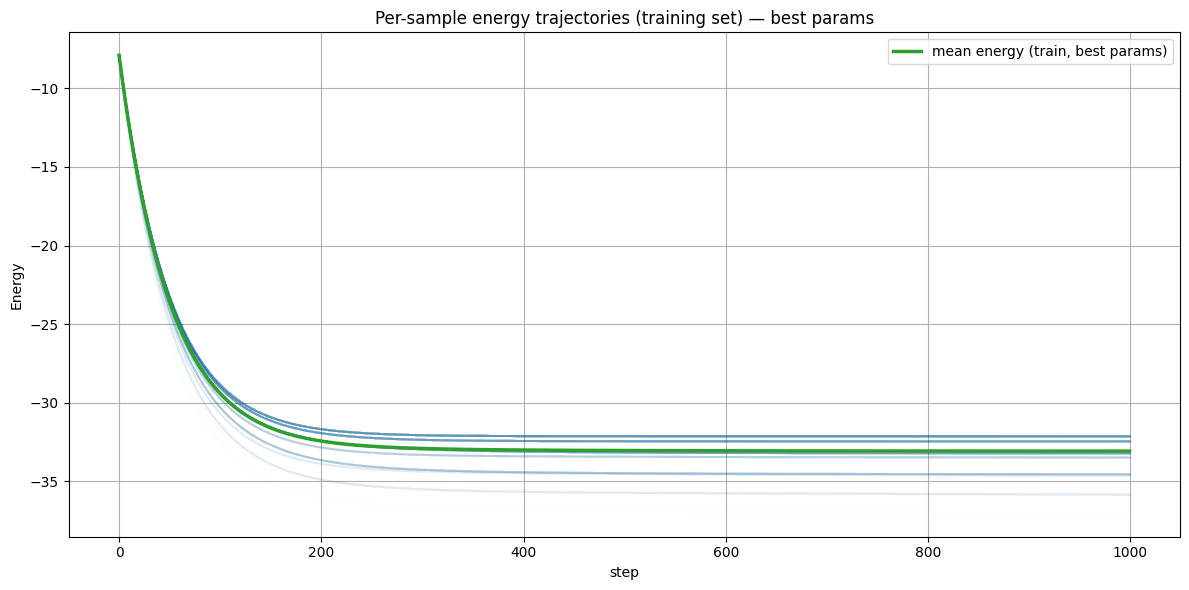

In [11]:
# Per-sample inference on training set
results_train_best = []
V0 = jnp.zeros((1, Config.D))
num_train_examples = int(train_X.shape[0])
for i in range(num_train_examples):
    ctx = train_X[i:i+1]
    V_T, F_T, E_traj = infer_forward_euler_with_engergies(params, V0, ctx) # type: ignore
    results_train_best.append(E_traj)
    if (i + 1) % 200 == 0 or i == num_train_examples - 1:
        print(f"(best) processed {i+1}/{num_train_examples} train examples; last E0={float(E_traj[0])}")

E_stack_train_best = jnp.stack(results_train_best, axis=1)
print('E_stack_train_best shape:', E_stack_train_best.shape)

# Plot per-sample training trajectories
E_train_best = np.array(E_stack_train_best)
T, N = E_train_best.shape
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(E_train_best[:, i], color='C0', alpha=0.02)
mean_traj_train_best = E_train_best.mean(axis=1)
plt.plot(mean_traj_train_best, color='C2', linewidth=2.5, label='mean energy (train, best params)')
plt.xlabel('step')
plt.ylabel('Energy')
plt.title('Per-sample energy trajectories (training set) — best params')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

processed 50/52 validation examples
processed 52/52 validation examples


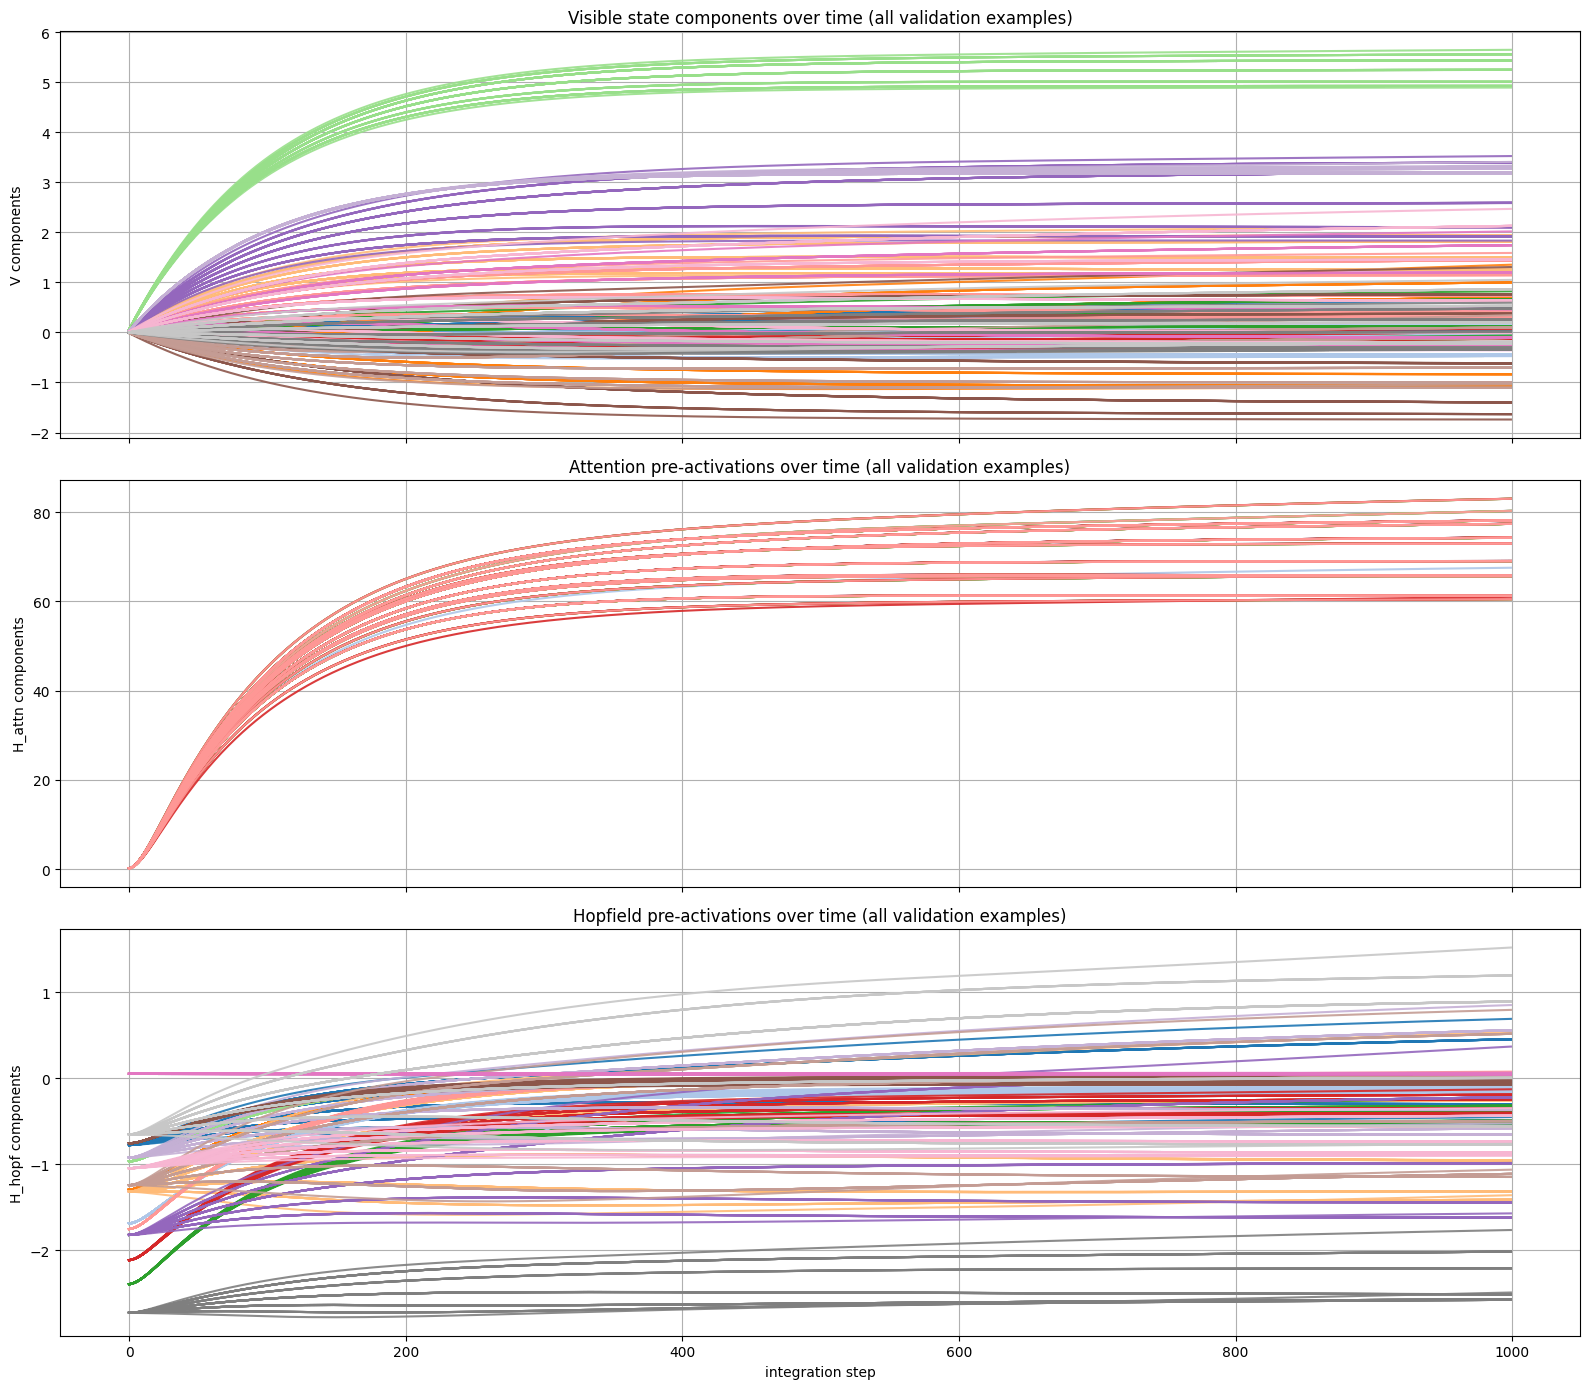

In [12]:
V0 = jnp.zeros((1, Config.D))
num_val = int(valid_X.shape[0])

results_V = []
results_H_attn = []
results_H_hopf = []

for i in range(num_val):
    ctx = valid_X[i:i+1]
    V_T, F_T, E_traj, V_traj, H_attn_traj, H_hopf_traj = infer_forward_euler_with_engergies( # type: ignore
        params, V0, ctx, save_hist=True
    )
    # squeeze batch axis -> (T, dim)
    results_V.append(np.array(V_traj).squeeze(axis=1))
    results_H_attn.append(np.array(H_attn_traj).squeeze(axis=1))
    results_H_hopf.append(np.array(H_hopf_traj).squeeze(axis=1))

    if (i + 1) % 50 == 0 or i == num_val - 1:
        print(f"processed {i+1}/{num_val} validation examples")

# Stack into arrays with shape (T, num_val, dim)
# results lists are length num_val of arrays (T, dim)
V_all = np.stack(results_V, axis=1)        # (T, num_val, D)
H_attn_all = np.stack(results_H_attn, axis=1)  # (T, num_val, L)
H_hopf_all = np.stack(results_H_hopf, axis=1) # (T, num_val, M)

T = V_all.shape[0]

# Plotting: for each component dimension, plot per-example traces (low alpha) and mean trace bold
fig, axs = plt.subplots(3, 1, figsize=(16, 14), sharex=True)

# colormap
cmap = plt.get_cmap('tab20')

# V components
for d in range(V_all.shape[2]):
    color = cmap(d % cmap.N)
    # per-example traces
    for n in range(V_all.shape[1]):
        axs[0].plot(np.arange(T), V_all[:, n, d], color=color, alpha=0.9)

axs[0].set_title('Visible state components over time (all validation examples)')
axs[0].set_ylabel('V components')
axs[0].grid(True)

# H_att components
for l in range(H_attn_all.shape[2]):
    color = cmap(l % cmap.N)
    for n in range(H_attn_all.shape[1]):
        axs[1].plot(np.arange(T), H_attn_all[:, n, l], color=color, alpha=0.9)

axs[1].set_title('Attention pre-activations over time (all validation examples)')
axs[1].set_ylabel('H_attn components')
axs[1].grid(True)

# H_hopf components
for m in range(H_hopf_all.shape[2]):
    color = cmap(m % cmap.N)
    for n in range(H_hopf_all.shape[1]):
        axs[2].plot(np.arange(T), H_hopf_all[:, n, m], color=color, alpha=0.9)

axs[2].set_title('Hopfield pre-activations over time (all validation examples)')
axs[2].set_ylabel('H_hopf components')
axs[2].set_xlabel('integration step')
axs[2].grid(True)

plt.tight_layout()
plt.show()

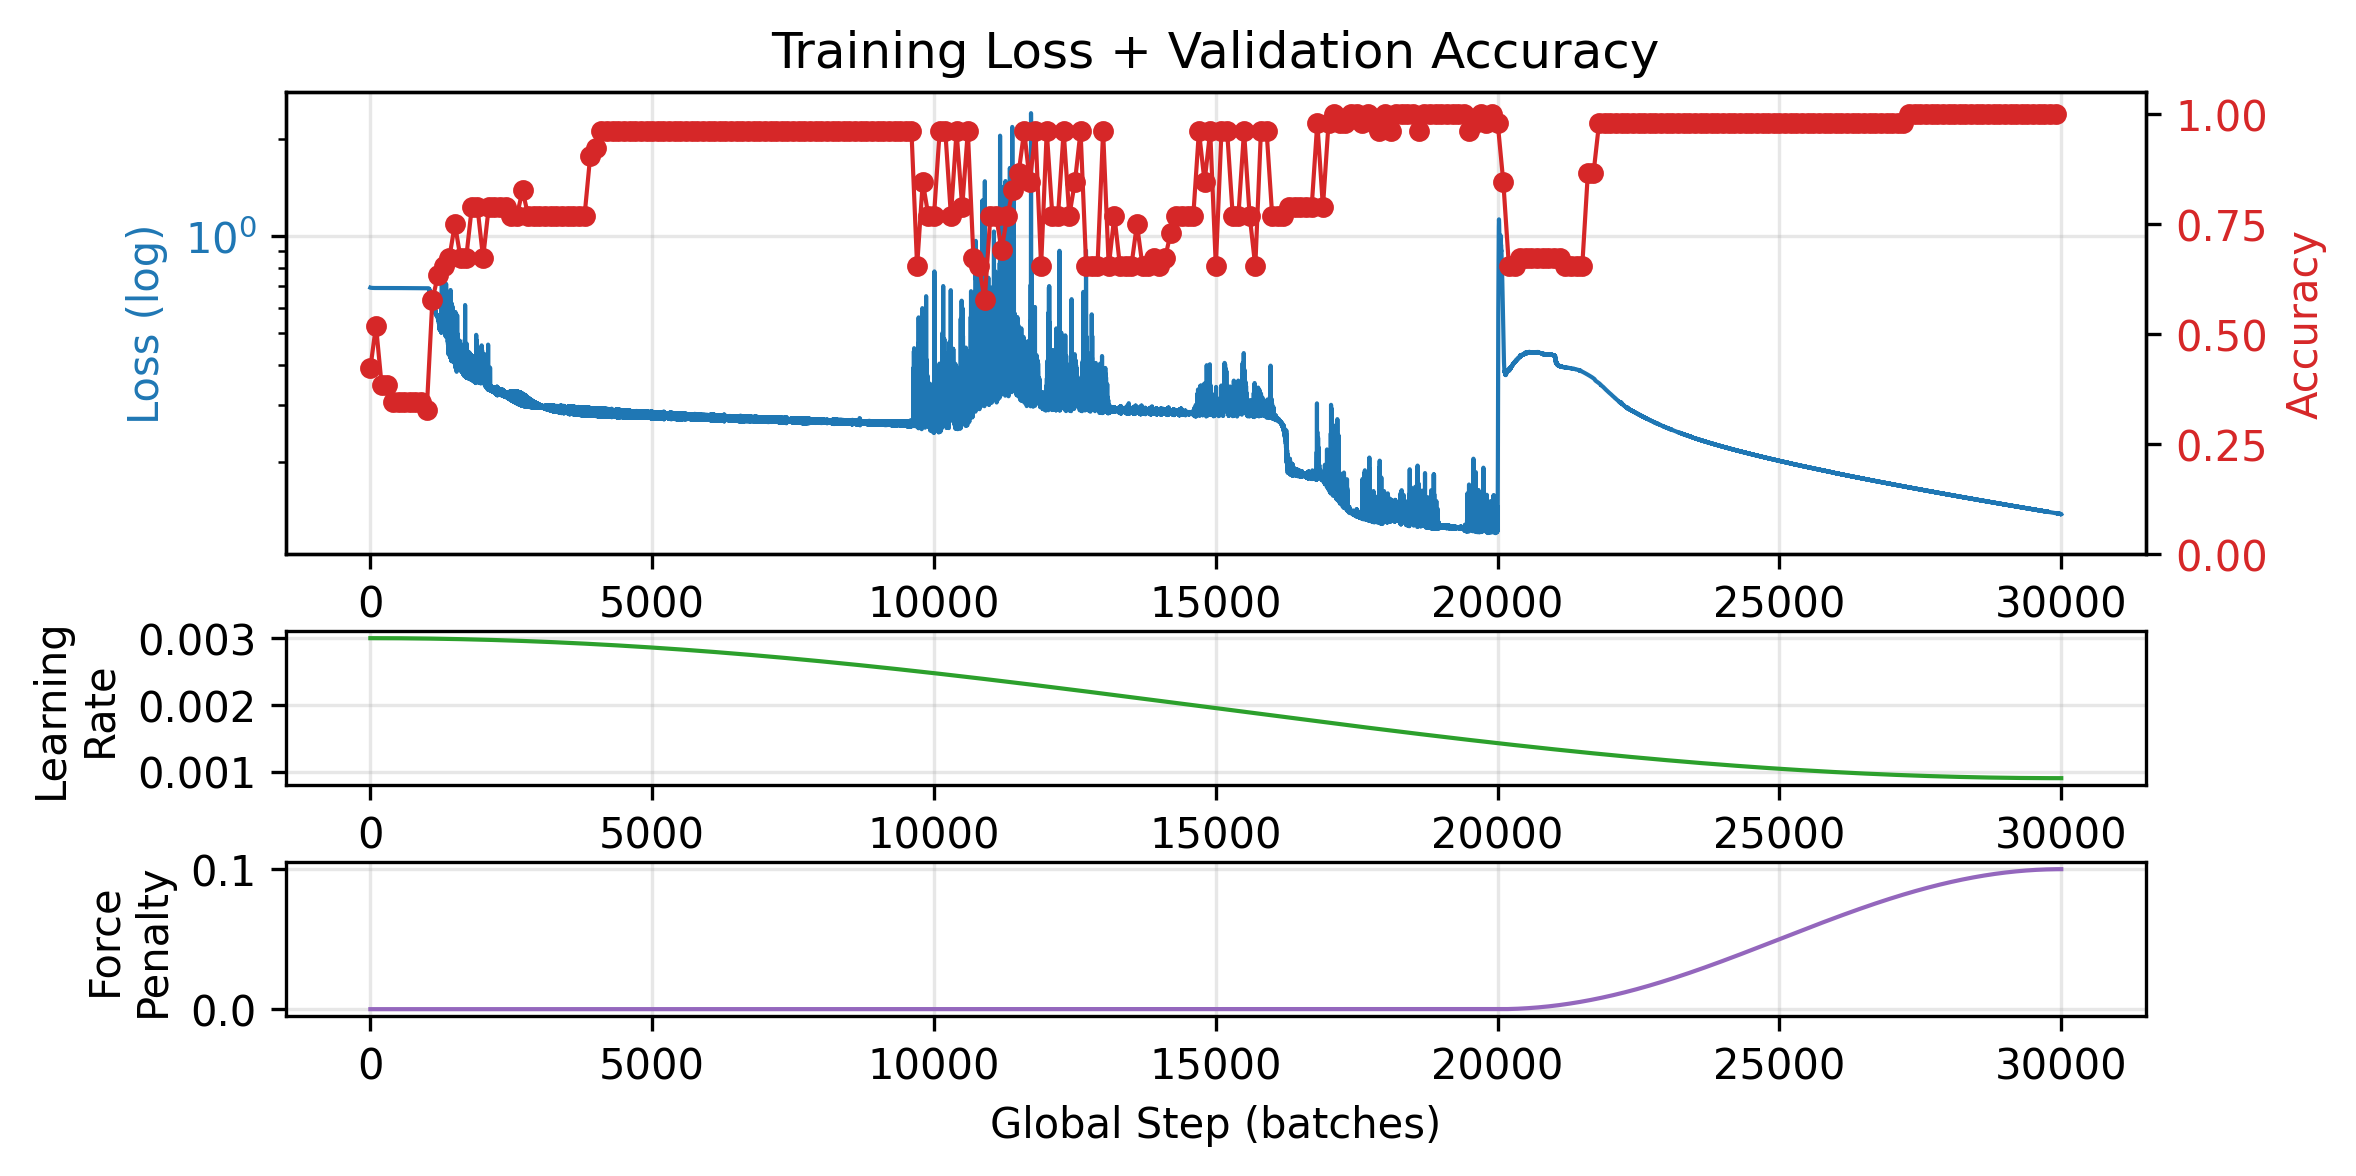

In [13]:
peak_lr = 3e-3
end_lr_factor = 0.3
warm = 0
total_steps = losses_steps[-1] + 1


def lr_value(global_step):
    if global_step < warm:
        return peak_lr * global_step / warm
    t = (global_step - warm) / max(1, total_steps - warm)
    cosine = 0.5 * (1 + math.cos(math.pi * t))
    return peak_lr * (end_lr_factor + (1 - end_lr_factor) * cosine)


lr_values = np.array([lr_value(s) for s in losses_steps])
force_vals_epoch = np.array([force_penalty_weight(e) for e in range(Config.train_epochs)])
epoch_axis = np.linspace(0, losses_steps[-1], Config.train_epochs)

fig = plt.figure(figsize=(8, 4), dpi=300)

# height_ratios: top = 3x taller than each lower subplot
gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 1], hspace=0.3)

# === Row 1 (tall): Loss + Accuracy ===
ax1 = fig.add_subplot(gs[0])
ax1.plot(losses_steps, losses_all, color="tab:blue", linewidth=1.0)
ax1.set_ylabel("Loss (log)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, alpha=0.3)
ax1.semilogy()

ax2 = ax1.twinx()
ax2.plot(
    accs_steps,
    accs_all,
    color="tab:red",
    marker="o",
    linestyle="-",
    linewidth=1.0,
    markersize=4,
)
ax2.set_ylabel("Accuracy", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_ylim(0.0, 1.05)
ax1.set_title("Training Loss + Validation Accuracy")


# === Row 2 (short): Learning Rate ===
ax3 = fig.add_subplot(gs[1])
ax3.plot(losses_steps, lr_values, color="tab:green", linewidth=1.0)
ax3.set_ylabel("Learning\nRate")
ax3.grid(True, alpha=0.3)


# === Row 3 (short): Force Penalty ===
ax4 = fig.add_subplot(gs[2])
ax4.plot(epoch_axis, force_vals_epoch, color="tab:purple", linewidth=1.0)
ax4.set_ylabel("Force\nPenalty")
ax4.set_xlabel("Global Step (batches)")
ax4.grid(True, alpha=0.3)


plt.show()